
## TURKISH
## Proje: Türkçe Metin Sınıflandırma
Bu projede, çeşitli Türkçe metinleri kategorilerine ayıran bir sınıflandırıcı geliştireceğiz. Kullanılacak model `SBERT` + `K-Means` olacak.

Veri kaynağı: Datas/data.csv
Hedef: 'content' sütunundaki metni kullanarak 'category' sütununu tahmin etmek.

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from collections import Counter
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import string
import re

In [2]:
df = pd.read_csv('../../Datas/data.csv')
df.head()
df.sample(n=5)

,category,content
1081,Spor,Fenerbahçe Voleybol Takımı 2017-18 sezonunda T...
971,Siyasi,Takrir-i Sükûn Kanunu (Osmanlıcası: تقرير سكون...
765,Kültürel,Vefa Lisesi Bahar Festivali 2004 yılından beri...
702,Kültürel,660. Kırkpınar Yağlı Güreşleri 9-11 Temmuz 202...
1238,Spor,"663. Kırkpınar Yağlı Güreşleri, 4-7 Temmuz 202..."


## İlk Gözlem
- `content`: metin verisi
- `category`: hedef sınıf (etiket)

In [3]:
# Boş değerleri sil.
# Küçük harfe çevir.
# Noktalama ve sayıları temizle.
# Stopwords temizliği yap.
# Stemming bu projede opsiyonel

nltk.download('stopwords')
stop_words = set(stopwords.words('turkish'))

def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df.dropna(subset=['content', 'category'], inplace=True)
df['processed_data'] = df['content'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\uslan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<Axes: xlabel='category'>

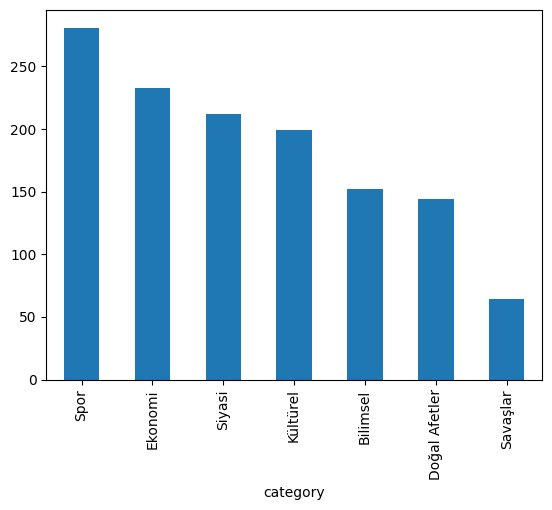

In [4]:
# Kategori dağılımını grafikle veya tabloda gör
df['category'].value_counts().plot(kind='bar')

In [5]:
from sentence_transformers import SentenceTransformer

# Türkçe metinler için uygun, hızlı bir SBERT modeli:
sbert_model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

# Embedding üretimi
X = sbert_model.encode(df['processed_data'].tolist(), show_progress_bar=True)

Batches:   0%|          | 0/41 [00:00<?, ?it/s]

In [ ]:

# Küme sayısı belirleyelim (örnek: 5)
# normalde 7 kategori var
num_clusters = 7

kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X)

df['cluster'] = clusters

df[['category', 'cluster']].head()
df.sample(n=5)

,category,content,processed_data,cluster
1262,Doğal Afetler,"1923 Salmatomruk Yangını, 9 Kasım 1923'te Kara...",salmatomruk yangını kasım te karagümrükteki sa...,1
1277,Doğal Afetler,Büyük Ankara Yangını; 1916 yılının Eylül ayınd...,büyük ankara yangını yılının eylül ayında anka...,1
689,Kültürel,JCI İstanbul Crossroads Uluslararası Kısa Film...,jci i̇stanbul crossroads uluslararası kısa fil...,4
599,Kültürel,İlk organizasyonu 15 Haziran - 15 Temmuz 1973 ...,i̇lk organizasyonu haziran temmuz tarihleri ar...,4
547,Ekonomi,NEVŞEHİR(MHA) Nevşehir-Acıgöl Organize Sanayi ...,nevşehi̇rmha nevşehiracıgöl organize sanayi bö...,0


In [7]:
le = LabelEncoder()
labels_num = le.fit_transform(df['category'])

cluster_label_map = {}
for cluster_id in np.unique(clusters):
    mask = (clusters == cluster_id)
    cluster_labels = labels_num[mask]
    if len(cluster_labels) == 0:
        continue
    most_common_num = Counter(cluster_labels).most_common(1)[0][0]
    cluster_label_map[cluster_id] = most_common_num

cluster_label_map_str = {cluster_id: le.inverse_transform([num])[0]
                         for cluster_id, num in cluster_label_map.items()}

predicted_num_categories = np.array([cluster_label_map[c] for c in clusters])
predicted_categories = le.inverse_transform(predicted_num_categories)

true_categories = df['category'].values
accuracy = accuracy_score(true_categories, predicted_categories)

print(f"K-Means doğruluk: {accuracy:.4f}")
for cid, cat in cluster_label_map_str.items():
    print(f"Cluster {cid} -> {cat}")

K-Means doğruluk: 0.5891
Cluster 0 -> Ekonomi
Cluster 1 -> Doğal Afetler
Cluster 2 -> Spor
Cluster 3 -> Ekonomi
Cluster 4 -> Kültürel
Cluster 5 -> Spor
Cluster 6 -> Siyasi


In [ ]:
import joblib
import os

target_base_dir = '../../Models/SBERT'

# Modelin tam kaydedileceği yol
model_save_path = os.path.join(target_base_dir, 'k-means_model.joblib')

try:
    # Hedef dizini oluştur. exist_ok=True sayesinde zaten varsa hata vermez.
    os.makedirs(target_base_dir, exist_ok=True)
    print(f"'{target_base_dir}' dizini başarıyla oluşturuldu veya zaten mevcut.")
    print(f"Modelin kaydedileceği tam yol: {os.path.abspath(model_save_path)}") # Tam yolu gösterelim
except Exception as e:
    print(f"Dizin oluşturulurken bir hata oluştu: {e}")
    exit()


# Modeli kaydet
try:
    joblib.dump(kmeans, model_save_path)
    print(f"Model '{model_save_path}' konumuna başarıyla kaydedildi.")
    joblib.dump(X, '../../Models/SBERT/embeddings.joblib')
    print(f"Embeddings '{model_save_path}' konumuna başarıyla kaydedildi.")
except Exception as e:
    print(f"Model kaydedilirken bir hata oluştu: {e}")

'../../Models/SBERT' dizini başarıyla oluşturuldu veya zaten mevcut.
Modelin kaydedileceği tam yol: c:\Users\uslan\OneDrive\Desktop\CENG Notes\3.Sınıf Dersleri\Machine Learning\Dejaview-CENG3522\Models\SBERT\k-means_model.joblib
Model '../../Models/SBERT\k-means_model.joblib' konumuna başarıyla kaydedildi.
Model '../../Models/SBERT\k-means_model.joblib' konumundan başarıyla yüklendi.
Yüklenen model içeriği: KMeans(n_clusters=7, n_init=10, random_state=42)


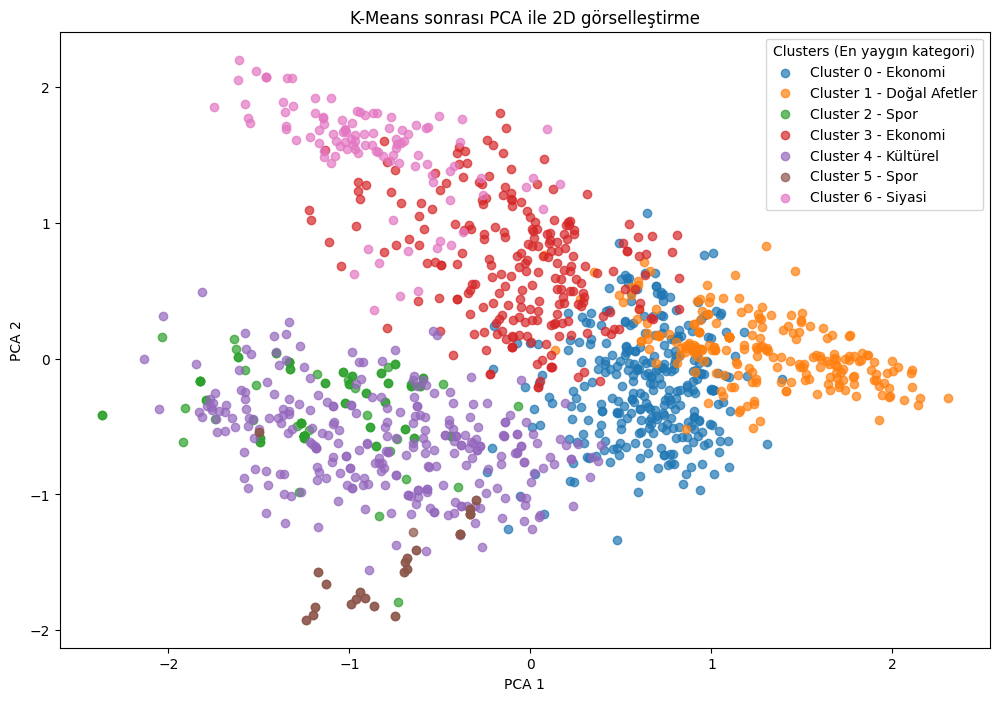

In [10]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# PCA ile 2 boyuta indir
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

num_clusters = len(np.unique(clusters))
colors = plt.cm.tab10.colors

plt.figure(figsize=(12,8))

for cluster_id in range(num_clusters):
    idx = np.where(clusters == cluster_id)
    plt.scatter(X_pca[idx,0], X_pca[idx,1], 
                color=colors[cluster_id % 10], 
                label=f"Cluster {cluster_id} - {cluster_label_map_str[cluster_id]}", 
                alpha=0.7)


plt.title('K-Means sonrası PCA ile 2D görselleştirme')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title="Clusters (En yaygın kategori)", loc='upper right')
plt.show()

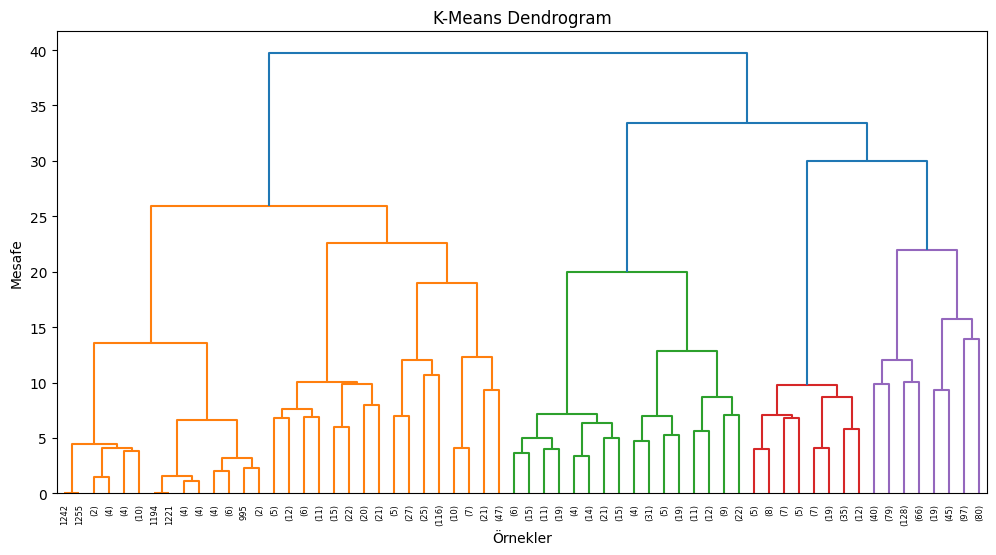

In [12]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

linked = linkage(X, method='ward')

plt.figure(figsize=(12, 6))
dendrogram(linked, truncate_mode='level', p=5)  # sadece ilk 5 seviyeyi gösterir
plt.title('K-Means Dendrogram')
plt.xlabel('Örnekler')
plt.ylabel('Mesafe')
plt.show()

## Grafik: Gerçek ve Tahmin Edilen Oranlar

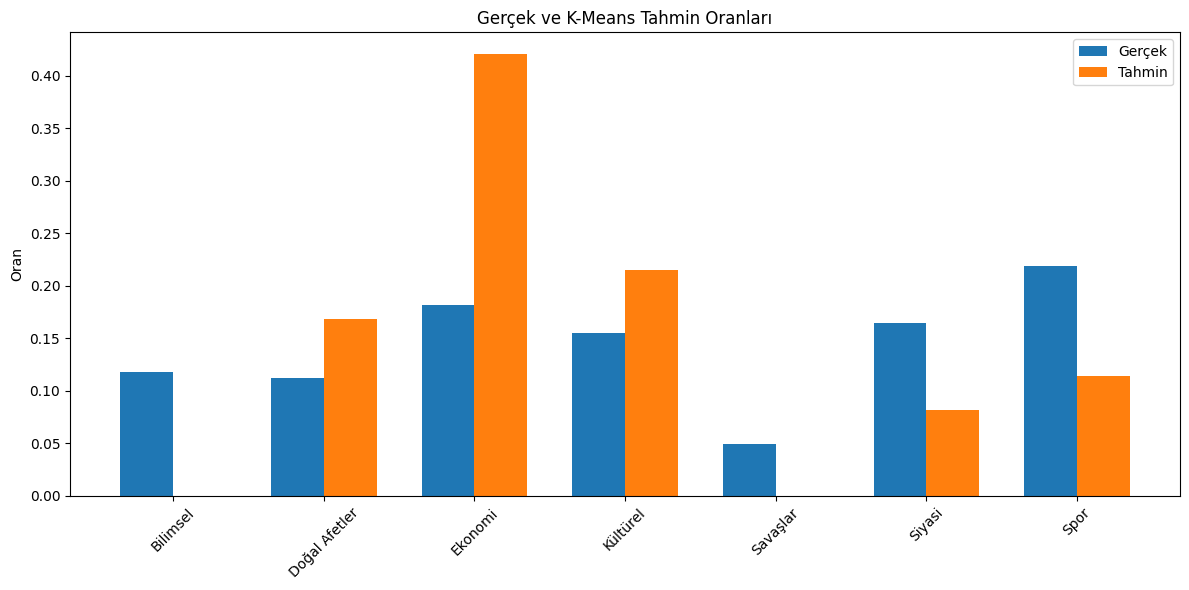

In [14]:
true_counts = df['category'].value_counts(normalize=True).sort_index()
predicted_counts = pd.Series(predicted_categories).value_counts(normalize=True).sort_index()

all_categories = sorted(set(true_counts.index).union(predicted_counts.index))
true_vals = [true_counts.get(cat, 0) for cat in all_categories]
predicted_vals = [predicted_counts.get(cat, 0) for cat in all_categories]

x = np.arange(len(all_categories))
width = 0.35

fig, ax = plt.subplots(figsize=(12,6))
ax.bar(x - width/2, true_vals, width, label='Gerçek')
ax.bar(x + width/2, predicted_vals, width, label='Tahmin')
ax.set_ylabel('Oran')
ax.set_title('Gerçek ve K-Means Tahmin Oranları')
ax.set_xticks(x)
ax.set_xticklabels(all_categories, rotation=45)
ax.legend()
plt.tight_layout()
plt.show()